# Fitting the data
I want to come up with a measure to calculate how long each of the shootings remained in the news. I'm going to look at several distributions that will describe the data well.

Possible distributions:
* Poisson
* log-normal
* skewed-normal

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from lmfit.models import SkewedGaussianModel, LognormalModel

In [2]:
#upload data, both sets for now
data_unnorm = pd.read_csv('full_data_unnormalized.csv', index_col=0, parse_dates=True)
data_max_norm = pd.read_csv('full_data_max_normalized.csv', index_col=0, parse_dates=True)

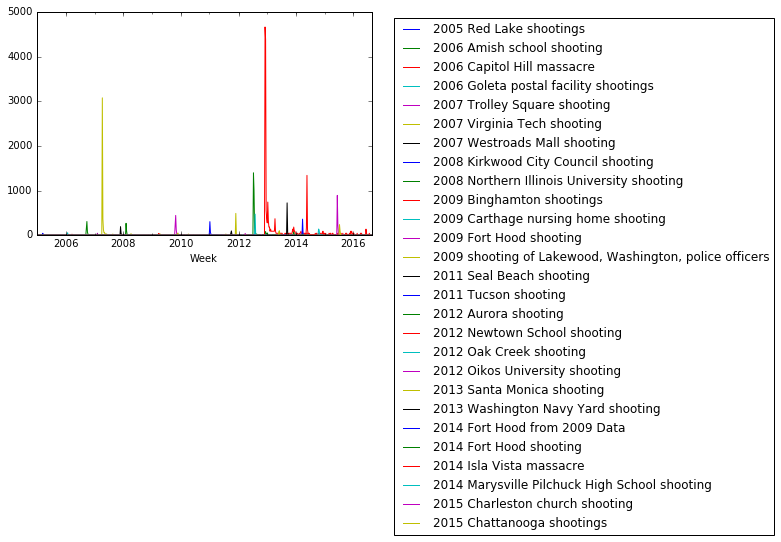

In [3]:
ax_unnorm = data_unnorm.plot()
ax_unnorm.legend(bbox_to_anchor=(1.05, 1), loc=2)

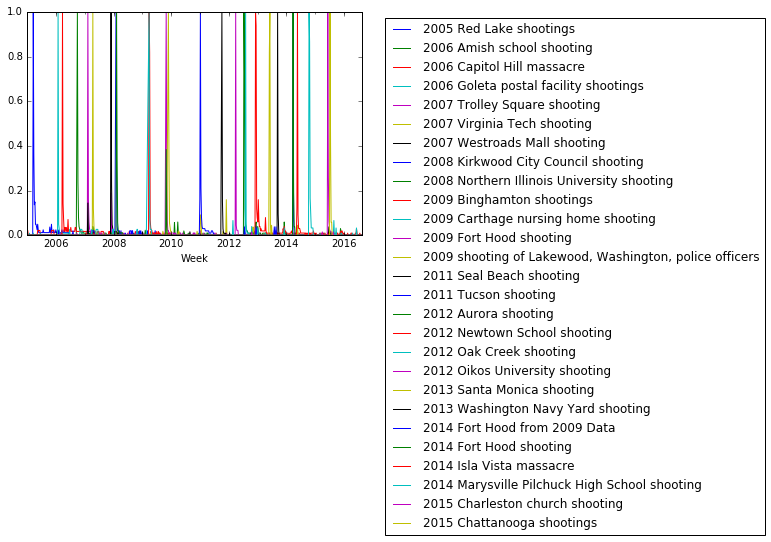

In [15]:
ax_max_norm = data_max_norm.plot()
ax_max_norm.legend(bbox_to_anchor=(1.05, 1), loc=2)

In [5]:
test = data_max_norm['2011 Seal Beach shooting']
print(test.idxmax().toordinal())
print(test.index[0].toordinal())

734418
731947


In [6]:
maxX = (test.idxmax().toordinal() - test.index[0].toordinal()) / 7
X = np.array(range(test.size))
print(X[0:10])
Y = test.values
print(Y[0:10])

[0 1 2 3 4 5 6 7 8 9]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


In [7]:
#lmfit does not support datetime objects
model = LognormalModel()
params = model.make_params()
params['center'].set(value=maxX)
params.pretty_print()

Name          Value      Min      Max   Stderr     Vary     Expr
amplitude         1     -inf      inf     None     True     None
center          353     -inf      inf     None     True     None
sigma             1     -inf      inf     None     True     None


Using the full data series in the fit wasn't working, so I will have to send in only a slice of the data. I will give the fit function data corresponding to two months on either side of the maximum.

[[Model]]
    Model(lognormal)
[[Fit Statistics]]
    # function evals   = 6
    # data points      = 16
    # variables        = 3
    chi-square         = 1.274
    reduced chi-square = 0.098
    Akaike info crit   = -34.489
    Bayesian info crit = -32.172
[[Variables]]
    center:      353        +/- 0        (0.00%) (init= 353)
    amplitude:   1          +/- 0        (0.00%) (init= 1)
    sigma:       1.00000001 +/- 0        (0.00%) (init= 1)
[[Correlations]] (unreported correlations are <  0.100)



//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  from ipykernel import kernelapp as app


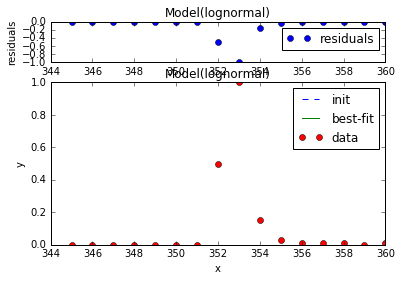

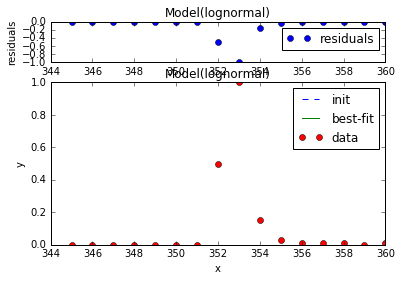

In [8]:
margin = 8
fit = model.fit(Y[maxX-margin:maxX+margin], params, x=X[maxX-margin:maxX+margin], fit_kws={'nan_policy': 'omit'})
print(fit.fit_report())
fit.plot()

The data set must be too small to fit, so I will have to try something else.

## Changing tactics
From the graph of the maximum normalized data, it looks like all the noise is below 0.2. Therefore, a count of the points above 0.2 should give a metric for how long the topic was in the news. It will at least allow for comparison.

In [9]:
data_max_norm[data_max_norm > 0.2].count()

2005 Red Lake shootings                                   2
2006 Amish school shooting                                3
2006 Capitol Hill massacre                                1
2006 Goleta postal facility shootings                     1
2007 Trolley Square shooting                              1
2007 Virginia Tech shooting                               1
2007 Westroads Mall shooting                              2
2008 Kirkwood City Council shooting                       3
2008 Northern Illinois University shooting                2
2009 Binghamton shootings                                 2
2009 Carthage nursing home shooting                       5
2009 Fort Hood shooting                                   3
2009 shooting of Lakewood, Washington, police officers    4
2011 Seal Beach shooting                                  2
2011 Tucson shooting                                      2
2012 Aurora shooting                                      2
2012 Newtown School shooting            

In [16]:
data_unnorm.max()

2005 Red Lake shootings                                     48.099875
2006 Amish school shooting                                 311.235605
2006 Capitol Hill massacre                                  27.056180
2006 Goleta postal facility shootings                       60.124844
2007 Trolley Square shooting                                48.314607
2007 Virginia Tech shooting                               3081.232493
2007 Westroads Mall shooting                               192.966075
2008 Kirkwood City Council shooting                         23.191011
2008 Northern Illinois University shooting                 270.774977
2009 Binghamton shootings                                   43.000000
2009 Carthage nursing home shooting                         17.876404
2009 Fort Hood shooting                                    447.619048
2009 shooting of Lakewood, Washington, police officers      54.000000
2011 Seal Beach shooting                                   100.000000
2011 Tucson shooting

In [57]:
compare = pd.concat([data_max_norm[data_max_norm > 0.2].count(),data_unnorm.max()],axis=1)
compare = compare.rename(columns={0: "Approx. weeks", 1: "Unnorm. max."})

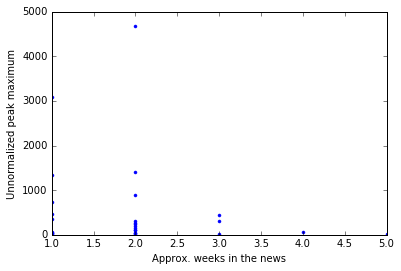

In [59]:
f, ax_compare = plt.subplots() 
ax_compare.plot(compare["Approx. weeks"], compare["Unnorm. max."],'.')
ax_compare.set_xlabel("Approx. weeks in the news")
ax_compare.set_ylabel("Unnormalized peak maximum")

In [60]:
avg = compare["Unnorm. max."].mean()
median = compare["Unnorm. max."].median()
print(avg, median)
n_below_avg = compare["Unnorm. max."][compare["Unnorm. max."] < avg].count()
n_below_median = compare["Unnorm. max."][compare["Unnorm. max."] < median].count()
print(n_below_avg, n_below_median)

572.8869173414963 192.96607531901648
21 13


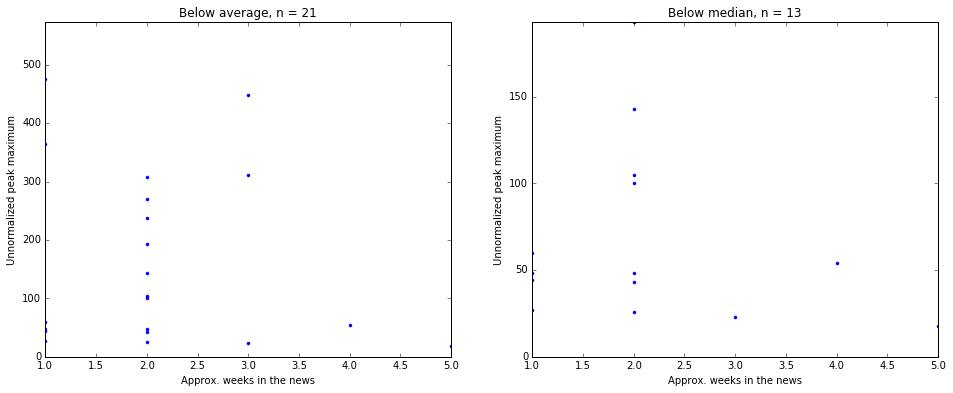

In [61]:
fig2, (ax_compare1, ax_compare2) = plt.subplots(1, 2, figsize=(16, 6))

ax_compare1.plot(compare["Approx. weeks"], compare["Unnorm. max."],'.')
ax_compare1.set_ylim(0, 573)
ax_compare1.set_title("Below average, n = {}".format(n_below_avg))
ax_compare1.set_xlabel("Approx. weeks in the news")
ax_compare1.set_ylabel("Unnormalized peak maximum")

ax_compare2.plot(compare["Approx. weeks"], compare["Unnorm. max."],'.')
ax_compare2.set_ylim(0, 193)
ax_compare2.set_title("Below median, n = {}".format(n_below_median))
ax_compare2.set_xlabel("Approx. weeks in the news")
ax_compare2.set_ylabel("Unnormalized peak maximum")

In [62]:
compare.corr()

,Approx. weeks,Unnorm. max.
Approx. weeks,1.000000,-0.174583
Unnorm. max.,-0.174583,1.000000


It appears that the length of time that the shooting stays in the news is negatively correlated with the unnormalized peak maximum, but not strongly. It is interesting to note that all of the shootings that stayed in the news for three or more weeks were less than the average and for four week or more were less than the median. A more accurate analysis could be done if data could be gathered on a daily basis. However, the window that Google Trends allows would be too small to overlap the data and construct one data set as done here.